**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Preprocessing](#toc1_2_)    
    - [Standardize](#toc1_2_1_)    
    - [Dataset Split](#toc1_2_2_)    
  - [Utilities](#toc1_3_)    
    - [Plots](#toc1_3_1_)    
  - [Shallow MLP](#toc1_4_)    
    - [Params](#toc1_4_1_)    
    - [Model](#toc1_4_2_)    
    - [Single train](#toc1_4_3_)    
    - [Plots](#toc1_4_4_)    
    - [Grid search](#toc1_4_5_)    
  - [DeepMLP](#toc1_5_)    
    - [Model](#toc1_5_1_)    
    - [Params](#toc1_5_2_)    
    - [Plots](#toc1_5_3_)    
  - [LSTM](#toc1_6_)    
    - [Model](#toc1_6_1_)    
    - [Params](#toc1_6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [77]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random

import csv

from sklearn.metrics import confusion_matrix

from codecarbon import track_emissions

In [2]:
seed =42
# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)
generator = torch.Generator().manual_seed(seed)

## <a id='toc1_2_'></a>[Preprocessing](#toc0_)

In [3]:
df = pd.read_excel('..//HeartFailure.xlsx')
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
for col in df.columns:
    if df[col].dtypes =='O':
        df[col] = pd.Categorical(df[col]).codes

df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [5]:
print(df['HeartDisease'].value_counts())

1    508
0    410
Name: HeartDisease, dtype: int64


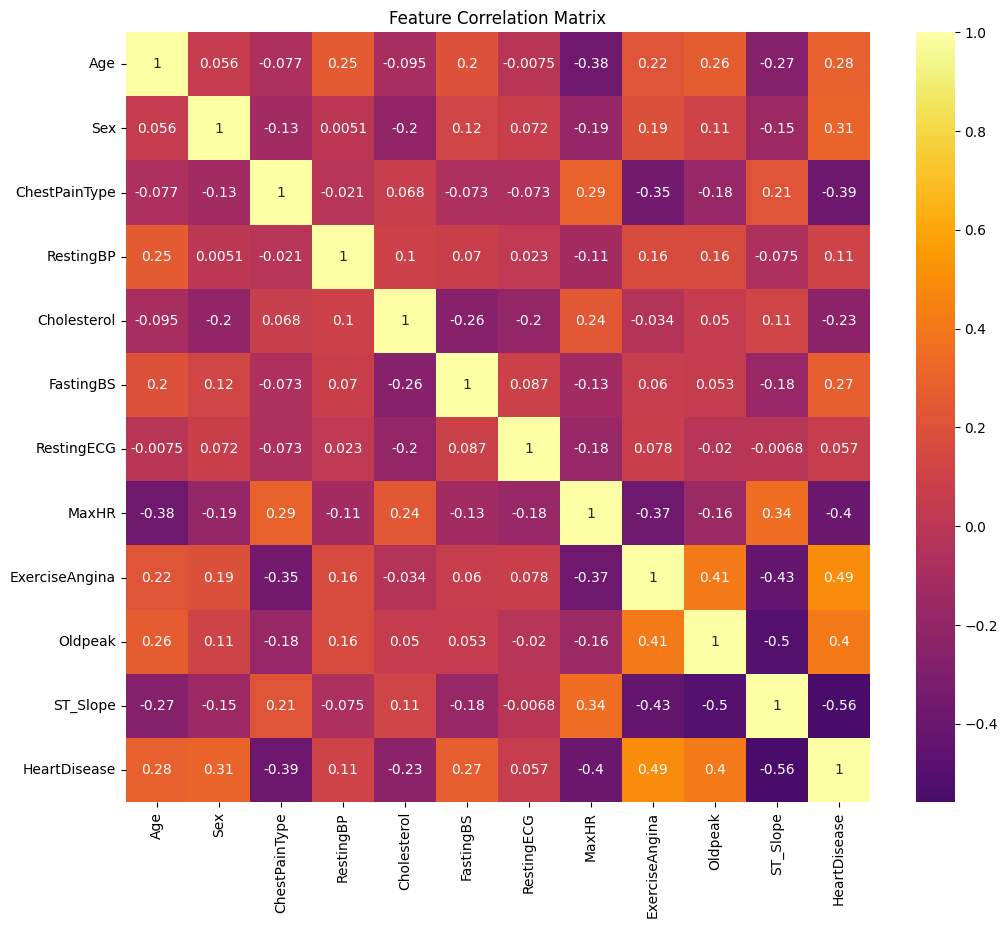

In [6]:
corr_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='inferno', center=0)
plt.title('Feature Correlation Matrix')
plt.show()



### <a id='toc1_2_1_'></a>[Standardize](#toc0_)

In [7]:
# Select the columns to be standardized
columns_to_standardize = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

### <a id='toc1_2_2_'></a>[Dataset Split](#toc0_)

In [8]:
'''
def split_data_lstm(df,lstm=False):
    #Split the dataset into training and testing sets
    X = df.drop('HeartDisease', axis=1).values
    y = df['HeartDisease'].values

    if lstm:
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        #y_tensor = torch.tensor(y, dtype=torch.long).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    else:
        # Convert data to PyTorch tensors
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    # Split data into training and test sets
    dataset = TensorDataset(X_tensor, y_tensor)
    train_val_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_val_size

    val_size = int(0.2 * train_val_size)  # 20% of the training data for validation
    train_size = train_val_size - val_size

    train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size],generator=generator)
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size],generator=generator)
    

    return train_dataset, val_dataset, test_dataset
'''

"\ndef split_data_lstm(df,lstm=False):\n    #Split the dataset into training and testing sets\n    X = df.drop('HeartDisease', axis=1).values\n    y = df['HeartDisease'].values\n\n    if lstm:\n        X = X.reshape((X.shape[0], 1, X.shape[1]))\n        #y_tensor = torch.tensor(y, dtype=torch.long).unsqueeze(1)\n        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)\n    else:\n        # Convert data to PyTorch tensors\n        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)\n\n    X_tensor = torch.tensor(X, dtype=torch.float32)\n    # Split data into training and test sets\n    dataset = TensorDataset(X_tensor, y_tensor)\n    train_val_size = int(0.8 * len(dataset))\n    test_size = len(dataset) - train_val_size\n\n    val_size = int(0.2 * train_val_size)  # 20% of the training data for validation\n    train_size = train_val_size - val_size\n\n    train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size],generator=generator)\n    tr

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_data_lstm(df, lstm=False):
    # Split the dataset into features (X) and labels (y)
    X = df.drop('HeartDisease', axis=1).values
    y = df['HeartDisease'].values

    if lstm:
        #X = X.reshape((X.shape[0], 1, X.shape[1]))
        
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    else:
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)

    # Combine features and labels into a PyTorch dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split data into training, validation, and test sets with stratification
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_val_indices, test_indices = next(sss.split(X, y))
    
    X_train_val, X_test = X[train_val_indices], X[test_indices]
    y_train_val, y_test = y[train_val_indices], y[test_indices]
    
    sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
    train_indices, val_indices = next(sss_inner.split(X_train_val, y_train_val))
    
    X_train, X_val = X_train_val[train_indices], X_train_val[val_indices]
    y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]

    # Print label distributions
    print(f"Training label distribution: {np.bincount(y_train.flatten().astype(int))}")
    print(f"Validation label distribution: {np.bincount(y_val.flatten().astype(int))}")
    print(f"Test label distribution: {np.bincount(y_test.flatten().astype(int))}")

    # Convert splits to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

    return train_tensor, val_tensor, test_tensor


## <a id='toc1_3_'></a>[Utilities](#toc0_)

### Summary

In [70]:
def summary(model, input_size, batch_size=-1, device="cuda"):
    """
    Print a summary of the PyTorch model.
    
    Args:
        model (torch.nn.Module): The PyTorch model.
        input_size (tuple): The input size of the model (e.g., (3, 224, 224) for an image with 3 channels and size 224x224).
        batch_size (int): The batch size. Set to -1 for dynamic batch size.
        device (str): The device to run the model on ("cuda" or "cpu").
    """
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if not isinstance(module, nn.Sequential) and not isinstance(
            module, nn.ModuleList
        ):
            hooks.append(module.register_forward_hook(hook))

    #device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size[0], (list, tuple)):
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    else:
        x = torch.rand(2, *input_size).type(dtype)

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    if isinstance(x, list):
        model(*x)
    else:
        model(x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")


### <a id='toc1_3_1_'></a>[Plots](#toc0_)

In [10]:
# Function to plot the losses

def plot_losses(train_losses, val_losses, dict_params):
    hyperparameters = ', '.join(f'{key}:{value}' for key, value in dict_params.items())
    
    plt.figure() 
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.text(0.5,  min(plt.ylim()) - 0.55, hyperparameters, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.legend()
    plt.show()

# Function to plot the losses
def save_plot_losses(train_losses, val_losses, params: dict, namefig):
    
    items = list(params.items())
    mid_index = len(items) // 2

    first_half = items[:mid_index]
    second_half = items[mid_index:]

    hyperparameters = ', '.join(f'{key}:{value}' for key, value in first_half)
    hyperparameters2 = ', '.join(f'{key}:{value}' for key, value in second_half)

    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.text(0.5,  min(plt.ylim()) - 0.55, hyperparameters, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5,  min(plt.ylim()) - 0.6, hyperparameters2, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.legend()
    plt.savefig(namefig, bbox_inches='tight')

In [25]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

### Dataloaders

In [11]:
# Create DataLoaders
def dataLoad(train_dataset, val_dataset, test_dataset, batch_size, generator):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    return train_loader, val_loader, test_loader


## <a id='toc1_4_'></a>[Shallow MLP](#toc0_)

### <a id='toc1_4_1_'></a>[Params](#toc0_)

In [15]:
num_epochs = 50
hidden_layer_dim = 8
batch_size = 16
lr = 0.001
input_size = (df.drop('HeartDisease', axis=1).values).shape[1]
dropout_prob = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### <a id='toc1_4_2_'></a>[Model](#toc0_)

In [10]:
# Define the simplest MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size,hidden_layer_dim, dropout_prob=0.5):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_dim)  
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_layer_dim, 1)  
        self.sigmoid = nn.Sigmoid()
        
        torch.manual_seed(seed) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Function to train the model
#@track_emissions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, printing = True):
    
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
         # Validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}')
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # Calculate F1 score
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, f1


### <a id='toc1_4_3_'></a>[Single train](#toc0_)

In [17]:
train_dataset, val_dataset, test_dataset = split_data_lstm(df)
train_loader, val_loader, test_loader = dataLoad(train_dataset, val_dataset, test_dataset, batch_size, generator)

# Initialize model, criterion, and optimizer
model = SimpleMLP(input_size,hidden_layer_dim, dropout_prob)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

# Train and evaluate the model
train_losses, val_losses = train_model(model, train_loader, val_loader,criterion, optimizer, num_epochs)
delta_loss = abs(val_losses[-1] - train_losses[-1])
test_acc, test_f1 = evaluate_model(model, test_loader)

Epoch 1/50, Loss: 0.6774
Epoch 2/50, Loss: 0.6521
Epoch 3/50, Loss: 0.6272
Epoch 4/50, Loss: 0.6144
Epoch 5/50, Loss: 0.5927
Epoch 6/50, Loss: 0.5793
Epoch 7/50, Loss: 0.5584
Epoch 8/50, Loss: 0.5556
Epoch 9/50, Loss: 0.5353
Epoch 10/50, Loss: 0.5136
Epoch 11/50, Loss: 0.5091
Epoch 12/50, Loss: 0.5098
Epoch 13/50, Loss: 0.5081
Epoch 14/50, Loss: 0.4796
Epoch 15/50, Loss: 0.4838
Epoch 16/50, Loss: 0.4854
Epoch 17/50, Loss: 0.4641
Epoch 18/50, Loss: 0.4590
Epoch 19/50, Loss: 0.4833
Epoch 20/50, Loss: 0.4805
Epoch 21/50, Loss: 0.4872
Epoch 22/50, Loss: 0.4755
Epoch 23/50, Loss: 0.4682
Epoch 24/50, Loss: 0.4471
Epoch 25/50, Loss: 0.4537
Epoch 26/50, Loss: 0.4354
Epoch 27/50, Loss: 0.4501
Epoch 28/50, Loss: 0.4345
Epoch 29/50, Loss: 0.4278
Epoch 30/50, Loss: 0.4203
Epoch 31/50, Loss: 0.4440
Epoch 32/50, Loss: 0.4635
Epoch 33/50, Loss: 0.4530
Epoch 34/50, Loss: 0.4308
Epoch 35/50, Loss: 0.4250
Epoch 36/50, Loss: 0.4355
Epoch 37/50, Loss: 0.4288
Epoch 38/50, Loss: 0.4393
Epoch 39/50, Loss: 0.

### <a id='toc1_4_4_'></a>[Plots](#toc0_)

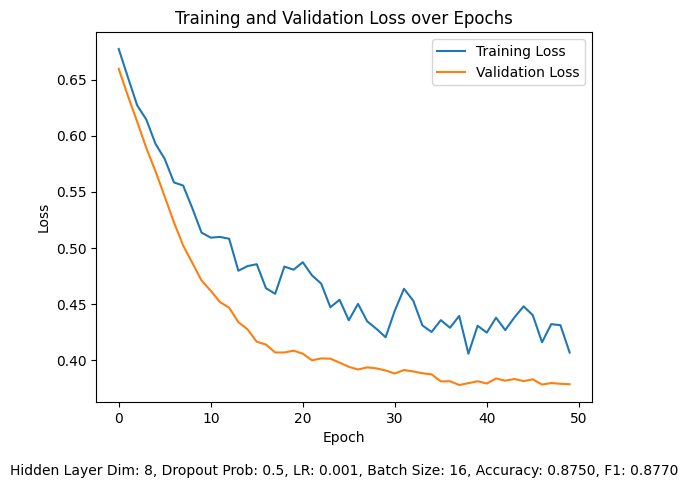

In [19]:
params_dict = {'num_epochs': num_epochs, 
               'hidden_layer_dim': hidden_layer_dim,
               'batch_size': batch_size, 
               'lr': lr,
               'dropout_prob': dropout_prob}

plot_losses(train_losses, val_losses,params_dict)

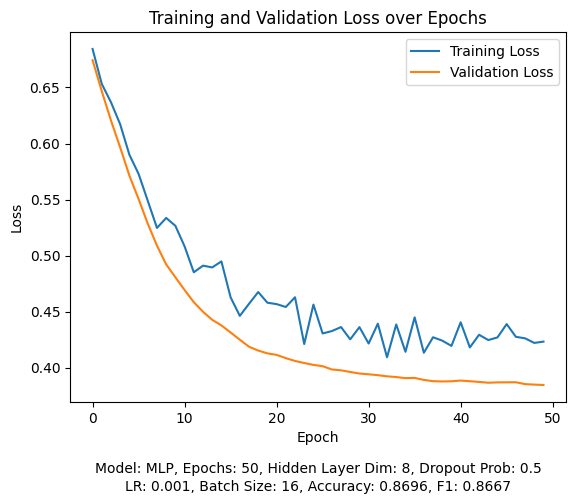

In [66]:
params_s = {
    'epochs': num_epochs,
    'hidden_layer_dim': hidden_layer_dim,
    'batch_size': batch_size,
    'lr': lr,
    'dropout': dropout_prob,
    'accuracy': test_acc,
    'f1': test_f1,
    'model': 'MLP'
}

namefig = f"..//Plots//{params_s['model']}_loss_E{params_s['epochs']}_H{params_s['hidden_layer_dim']}_B{params_s['batch_size']}_L{str(params_s['lr']).replace('.', ',')}.png"

save_plot_losses(train_losses, val_losses, params_s, namefig)


### <a id='toc1_4_5_'></a>[Grid search](#toc0_)

In [68]:

num_epochs_arr= [40,50]
hidden_layer_dim_arr= [8,16,32,64]
batch_size_arr= [8,16,32,64]
lr_arr= [0.001, 0.01, 0.1]


In [70]:


# Define the path to the CSV file
csv_file = '..//Grid_results//simpleMLP_results_4.csv'

# Open the CSV file in write mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['num_epochs', 'hidden_layer_dim', 'batch_size', 'lr', 'test_accuracy','test_f1','delta_loss'])


    for epoch in num_epochs_arr:
        for hidden_layer_dim in hidden_layer_dim_arr:
            for batch_size in batch_size_arr:
                for lr in lr_arr:
                    print(f'num_epochs: {epoch}, hidden_layer_dim: {hidden_layer_dim}, batch_size: {batch_size}, lr: {lr}')
                    # Create DataLoaders
                    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
                    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,generator=generator)

                    # Initialize model, criterion, and optimizer
                    model = SimpleMLP(input_size,hidden_layer_dim, dropout_prob)
                    criterion = nn.BCELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

                    # Train and evaluate the model
                    train_losses, val_losses = train_model(model, train_loader,val_loader, criterion, optimizer, epoch, printing=False)
                    delta_loss = abs(val_losses[-1] - train_losses[-1])
                    test_acc, test_f1 = evaluate_model(model, test_loader)
                    
                    writer.writerow([epoch, hidden_layer_dim, batch_size, lr, test_acc,test_f1,delta_loss])
                    

num_epochs: 40, hidden_layer_dim: 8, batch_size: 8, lr: 0.001
Test Accuracy: 0.8478
F1 Score: 0.8462
num_epochs: 40, hidden_layer_dim: 8, batch_size: 8, lr: 0.01
Test Accuracy: 0.8804
F1 Score: 0.8830
num_epochs: 40, hidden_layer_dim: 8, batch_size: 8, lr: 0.1
Test Accuracy: 0.8641
F1 Score: 0.8571
num_epochs: 40, hidden_layer_dim: 8, batch_size: 16, lr: 0.001
Test Accuracy: 0.8261
F1 Score: 0.8261
num_epochs: 40, hidden_layer_dim: 8, batch_size: 16, lr: 0.01
Test Accuracy: 0.8750
F1 Score: 0.8770
num_epochs: 40, hidden_layer_dim: 8, batch_size: 16, lr: 0.1
Test Accuracy: 0.8424
F1 Score: 0.8221
num_epochs: 40, hidden_layer_dim: 8, batch_size: 32, lr: 0.001
Test Accuracy: 0.8315
F1 Score: 0.8324
num_epochs: 40, hidden_layer_dim: 8, batch_size: 32, lr: 0.01
Test Accuracy: 0.8804
F1 Score: 0.8830
num_epochs: 40, hidden_layer_dim: 8, batch_size: 32, lr: 0.1
Test Accuracy: 0.8587
F1 Score: 0.8523
num_epochs: 40, hidden_layer_dim: 8, batch_size: 64, lr: 0.001
Test Accuracy: 0.8315
F1 Score:

In [71]:
results = pd.read_csv(csv_file)
max_test_accuracy_row = results.loc[results['test_accuracy'].idxmax()]
print(max_test_accuracy_row)

num_epochs          50.000000
hidden_layer_dim    32.000000
batch_size          16.000000
lr                   0.010000
test_accuracy        0.885870
test_f1              0.886486
delta_loss           0.208176
Name: 76, dtype: float64


In [73]:
results = pd.read_csv(csv_file)
max_test_f1_row = results.loc[results['test_f1'].idxmax()]
print(max_test_f1_row)

num_epochs          50.000000
hidden_layer_dim    32.000000
batch_size          16.000000
lr                   0.010000
test_accuracy        0.885870
test_f1              0.886486
delta_loss           0.208176
Name: 76, dtype: float64


In [72]:
results = pd.read_csv(csv_file)
min_deltaloss_row = results.loc[results['delta_loss'].idxmin()]
print(min_deltaloss_row)

num_epochs          40.000000
hidden_layer_dim     8.000000
batch_size          16.000000
lr                   0.001000
test_accuracy        0.826087
test_f1              0.826087
delta_loss           0.002269
Name: 3, dtype: float64


## <a id='toc1_5_'></a>[DeepMLP](#toc0_)

### <a id='toc1_5_1_'></a>[Model](#toc0_)

In [8]:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_layer_dims, dropout_prob=0.5):
        super(DeepMLP, self).__init__()
        
        layers = []
        current_input_size = input_size
        
        for hidden_dim in hidden_layer_dims:
            layers.append(nn.Linear(current_input_size, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            current_input_size = hidden_dim
        
        layers.append(nn.Linear(current_input_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, printing=True):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # Calculate F1 score
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, f1


### <a id='toc1_5_2_'></a>[Params](#toc0_)

In [130]:
input_size = X.shape[1]
hidden_layer_dims = [32, 16, 16]#[24,32,16,8,1]
batch_size_d = 8
dropout_prob_d = 0.3
lr_d = 0.0001
num_epochs_d = 200


In [131]:
train_loader_d, val_loader_d, test_loader_d = dataLoad(train_dataset, val_dataset, test_dataset, batch_size_d, generator)

In [132]:
# Initialize model, criterion, and optimizer
model_deep = DeepMLP(input_size, hidden_layer_dims, dropout_prob)
criterion_d = nn.BCELoss()
optimizer_d = optim.Adam(model_deep.parameters(), lr=lr_d,weight_decay=1e-4)

# Train and evaluate the model
train_losses_d, val_losses_d = train_model(model_deep, train_loader_d, val_loader_d,criterion_d, optimizer_d, num_epochs_d)
delta_loss_d = abs(val_losses_d[-1] - train_losses_d[-1])
test_acc_d, test_f1_d = evaluate_model(model_deep, test_loader_d)

Epoch 1/200, Loss: 0.7123, Val Loss: 0.7089
Epoch 2/200, Loss: 0.7132, Val Loss: 0.7060
Epoch 3/200, Loss: 0.7067, Val Loss: 0.7036
Epoch 4/200, Loss: 0.7050, Val Loss: 0.7004
Epoch 5/200, Loss: 0.7052, Val Loss: 0.6980
Epoch 6/200, Loss: 0.7011, Val Loss: 0.6955
Epoch 7/200, Loss: 0.6976, Val Loss: 0.6929
Epoch 8/200, Loss: 0.6941, Val Loss: 0.6902
Epoch 9/200, Loss: 0.6975, Val Loss: 0.6880
Epoch 10/200, Loss: 0.6900, Val Loss: 0.6854
Epoch 11/200, Loss: 0.6869, Val Loss: 0.6821
Epoch 12/200, Loss: 0.6812, Val Loss: 0.6790
Epoch 13/200, Loss: 0.6789, Val Loss: 0.6756
Epoch 14/200, Loss: 0.6751, Val Loss: 0.6718
Epoch 15/200, Loss: 0.6809, Val Loss: 0.6681
Epoch 16/200, Loss: 0.6767, Val Loss: 0.6642
Epoch 17/200, Loss: 0.6797, Val Loss: 0.6605
Epoch 18/200, Loss: 0.6704, Val Loss: 0.6558
Epoch 19/200, Loss: 0.6673, Val Loss: 0.6507
Epoch 20/200, Loss: 0.6627, Val Loss: 0.6455
Epoch 21/200, Loss: 0.6596, Val Loss: 0.6399
Epoch 22/200, Loss: 0.6465, Val Loss: 0.6330
Epoch 23/200, Loss:

### <a id='toc1_5_3_'></a>[Plots](#toc0_)

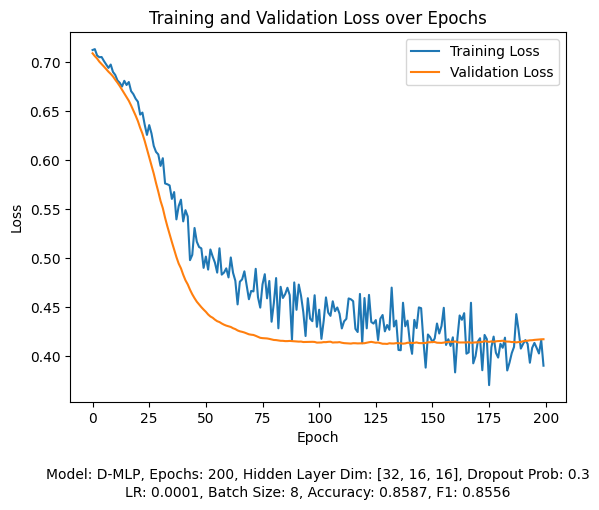

In [133]:
params_d = {
    'epochs': num_epochs_d,
    'hidden_layer_dim': hidden_layer_dims,
    'batch_size': batch_size_d,
    'lr': lr_d,
    'dropout': dropout_prob_d,
    'accuracy': test_acc_d,
    'f1': test_f1_d,
    'model': 'D-MLP'
}
save_plot_losses(train_losses_d, val_losses_d,params_d)

## <a id='toc1_6_'></a>[LSTM](#toc0_)

### <a id='toc1_6_1_'></a>[Model](#toc0_)

In [79]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout_prob=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        x.unsqueeze_(1)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    model.train()
    
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        # Training phase
        model.train()
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(features)
                
                loss = criterion(outputs, labels)
                
                epoch_val_loss += loss.item()
        
        val_losses.append(epoch_val_loss / len(val_loader))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')
        
    
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader,device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()  # Apply threshold
            #_, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return accuracy, f1, precision, recall, y_true, y_pred


### <a id='toc1_6_2_'></a>[Params](#toc0_)

In [63]:
# Model parameters
lstm_params = {
    'input_size' : 11,
    'hidden_size' : 64,
    'num_layers' : 3,
    'output_size' : 1 , # Binary classification
    'num_epochs' : 100,
    'learning_rate' : 0.0001,
    'batch_size' : 32,
    'dropout_prob' : 0.5
}


### Train

In [80]:
train_dataset_lstm, val_dataset_lstm, test_dataset_lstm = split_data_lstm(df,lstm=True)

train_loader_lstm, val_loader_lstm, test_loader_lstm = dataLoad(train_dataset_lstm, val_dataset_lstm, test_dataset_lstm, lstm_params['batch_size'], generator)

Training label distribution: [246 304]
Validation label distribution: [ 82 102]
Test label distribution: [ 82 102]


In [72]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(lstm_params['input_size'], lstm_params['hidden_size'], lstm_params['num_layers'],  lstm_params['output_size'])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr= lstm_params['learning_rate'])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses, val_losses = train_model(model, train_loader_lstm, val_loader_lstm ,criterion, optimizer, lstm_params['num_epochs'], device)
test_acc, test_f1, precision, recall, y_true, y_pred = evaluate_model(model, test_loader_lstm,device)


Epoch [1/100], Train Loss: 0.6928, Validation Loss: 0.6925
Epoch [2/100], Train Loss: 0.6921, Validation Loss: 0.6918
Epoch [3/100], Train Loss: 0.6913, Validation Loss: 0.6910
Epoch [4/100], Train Loss: 0.6904, Validation Loss: 0.6901
Epoch [5/100], Train Loss: 0.6894, Validation Loss: 0.6890
Epoch [6/100], Train Loss: 0.6881, Validation Loss: 0.6877
Epoch [7/100], Train Loss: 0.6866, Validation Loss: 0.6861
Epoch [8/100], Train Loss: 0.6844, Validation Loss: 0.6840
Epoch [9/100], Train Loss: 0.6817, Validation Loss: 0.6812
Epoch [10/100], Train Loss: 0.6782, Validation Loss: 0.6776
Epoch [11/100], Train Loss: 0.6736, Validation Loss: 0.6730
Epoch [12/100], Train Loss: 0.6679, Validation Loss: 0.6670
Epoch [13/100], Train Loss: 0.6601, Validation Loss: 0.6591
Epoch [14/100], Train Loss: 0.6502, Validation Loss: 0.6493
Epoch [15/100], Train Loss: 0.6369, Validation Loss: 0.6369
Epoch [16/100], Train Loss: 0.6210, Validation Loss: 0.6220
Epoch [17/100], Train Loss: 0.6002, Validation Lo

### Plots

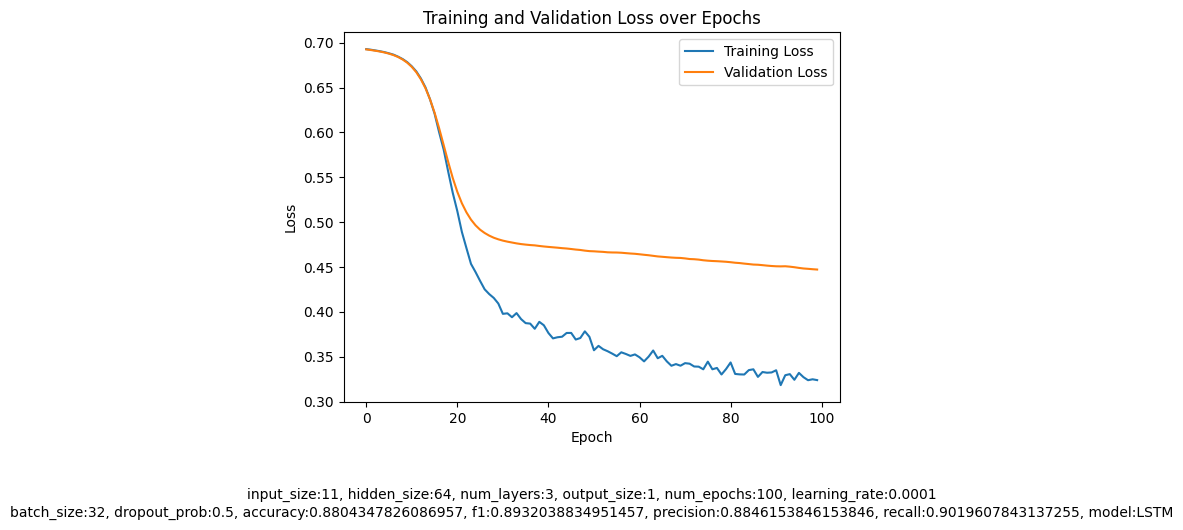

In [73]:
lstm_params.update({
                        'accuracy': test_acc,
                        'f1': test_f1,
                        'precision': precision,
                        'recall': recall,
                        'model': 'LSTM'
                    }
                   )

namefig = f"..//Plots//{lstm_params['model']}//loss_E{lstm_params['num_epochs']}_H{lstm_params['hidden_size']}_B{lstm_params['batch_size']}_L{str(lstm_params['learning_rate']).replace('.', ',')}.png"

save_plot_losses(train_losses, val_losses, lstm_params, namefig)

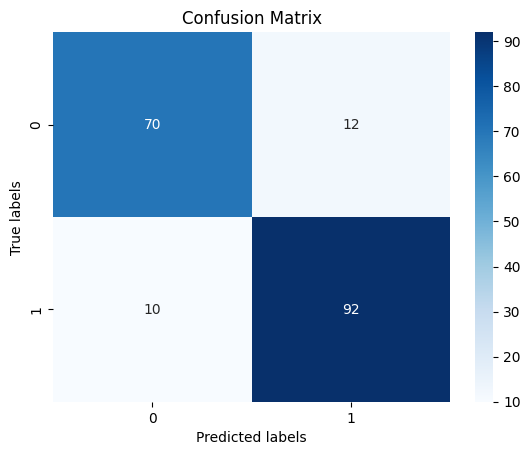

In [74]:
plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix')

### Grid Search

In [88]:
lstm_params_grid = {
    'input_size' : 11,
    'hidden_size' : [16,32,64],
    'num_layers' : [1,2,4],
    'output_size' : 1 , # Binary classification
    'num_epochs' : [50,100],
    'learning_rate' : [0.0001, 0.0005 ,0.001],
    'batch_size' : [8,16,32],
    'dropout_prob' : 0.4
}

In [90]:
@track_emissions
def grid_search():
    # Define the path to the CSV file
    csv_file = '..//Grid_results//LSTM//results_2.csv'

    # Open the CSV file in write mode
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row
        writer.writerow(['num_epochs', 'hidden_size', 'num_layers', 'batch_size', 'lr', 'test_accuracy','test_f1','precision','recall','y_true','y_pred'])
        
        for epochs in lstm_params_grid['num_epochs']:
            for hidden_size in lstm_params_grid['hidden_size']:
                for num_layers in lstm_params_grid['num_layers']:
                    for batch_size in lstm_params_grid['batch_size']:
                        for lr in lstm_params_grid['learning_rate']:
                            # Initialize the model, loss function, and optimizer
                            model = LSTMModel(lstm_params_grid['input_size'], hidden_size, num_layers,  lstm_params_grid['output_size'])
                            criterion = nn.BCEWithLogitsLoss()
                            optimizer = optim.Adam(model.parameters(), lr= lr)

                            # Device configuration
                            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                            model = model.to(device)

                            train_losses, val_losses = train_model(model, train_loader_lstm, val_loader_lstm ,criterion, optimizer, epochs, device)
                            test_acc, test_f1, precision, recall, y_true, y_pred = evaluate_model(model, test_loader_lstm,device)
                            
                            run_params = {
                                'input_size' : lstm_params_grid['input_size'],
                                'hidden_size' : hidden_size,
                                'num_layers' : num_layers,
                                'output_size' : lstm_params_grid['output_size'] , # Binary classification
                                'num_epochs' : epochs,
                                'learning_rate' : lr,
                                'batch_size' : batch_size,
                                'dropout_prob' : lstm_params_grid['dropout_prob'],
                                'accuracy': test_acc,
                                'f1': test_f1,
                                'precision': precision,
                                'recall': recall,
                                'model': 'LSTM'
                            }
        
                            namefig = f"..//Plots//{run_params['model']}//loss_E{epochs}_H{hidden_size}_NL{num_layers}_B{batch_size}_L{str(lr).replace('.', ',')}.png"

                            save_plot_losses(train_losses, val_losses, run_params, namefig)
                            writer.writerow([epochs, hidden_size, num_layers, batch_size, lr, test_acc, test_f1, precision, recall,y_true,y_pred])
                            

grid_search()

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


In [84]:
results = pd.read_csv(csv_file)
# Assuming the DataFrame variable is named 'df'
max_accuracy_row = results[results['test_accuracy'] == results['test_accuracy'].max()]
max_f1score_row = results[results['test_f1'] == results['test_f1'].max()]

print("Row with maximum accuracy:")
print(max_accuracy_row)



Row with maximum accuracy:
     num_epochs  hidden_size  num_layers  batch_size      lr  test_accuracy  \
108         100           32           1           8  0.0001       0.896739   
117         100           32           2           8  0.0001       0.896739   

      test_f1  precision    recall  \
108  0.907317   0.902913  0.911765   
117  0.907317   0.902913  0.911765   

                                                y_true  \
108  [array([1.], dtype=float32), array([1.], dtype...   
117  [array([1.], dtype=float32), array([1.], dtype...   

                                                y_pred  
108  [array([1.], dtype=float32), array([0.], dtype...  
117  [array([1.], dtype=float32), array([0.], dtype...  
Row with maximum f1 score:
     num_epochs  hidden_size  num_layers  batch_size      lr  test_accuracy  \
108         100           32           1           8  0.0001       0.896739   
117         100           32           2           8  0.0001       0.896739   

      tes

In [85]:
print("Row with maximum f1 score:")
print(max_f1score_row)

Row with maximum f1 score:
     num_epochs  hidden_size  num_layers  batch_size      lr  test_accuracy  \
108         100           32           1           8  0.0001       0.896739   
117         100           32           2           8  0.0001       0.896739   

      test_f1  precision    recall  \
108  0.907317   0.902913  0.911765   
117  0.907317   0.902913  0.911765   

                                                y_true  \
108  [array([1.], dtype=float32), array([1.], dtype...   
117  [array([1.], dtype=float32), array([1.], dtype...   

                                                y_pred  
108  [array([1.], dtype=float32), array([0.], dtype...  
117  [array([1.], dtype=float32), array([0.], dtype...  
